# Results Analysis on SummEval

## Imports

In [19]:
import pandas as pd
import ast
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

## Analysis

In [20]:
files = {
    "Single": "Results/single.csv",
    "Parallel": "Results/parallel.csv",
    "Cooperative": "Results/cooperative.csv",
    "Competitive": "Results/competitive.csv"
}

def parse_and_evaluate(path):
    df = pd.read_csv(path)
    parsed = {dim: df[dim].apply(ast.literal_eval) for dim in df.columns}
    gt = pd.DataFrame({dim: parsed[dim].apply(lambda x: x["ground_truth"]) for dim in parsed})
    sys = pd.DataFrame({dim: parsed[dim].apply(lambda x: x["system_decision"]) for dim in parsed})
    dev = pd.DataFrame({dim: parsed[dim].apply(lambda x: x["deviation"]) for dim in parsed})
    
    kendalls = {dim: kendalltau(gt[dim], sys[dim]).correlation for dim in gt.columns}
    avg_kendall = sum(kendalls.values()) / len(kendalls)
    avg_dev_dim = dev.mean().to_dict()
    avg_dev_all = dev.values.flatten().mean()
    avg_gt_dim = gt.mean().to_dict()
    avg_sys_dim = sys.mean().to_dict()
    avg_gt_all = gt.values.flatten().mean()
    avg_sys_all = sys.values.flatten().mean()

    summary = pd.DataFrame({
        "Kendall Tau": kendalls,
        "Ø Abweichung": avg_dev_dim,
        "Ø Ground Truth": avg_gt_dim,
        "Ø System": avg_sys_dim
    })

    overview = {
        "Ø Kendall Tau (Dimensionen)": avg_kendall,
        "Ø Abweichung (gesamt)": avg_dev_all,
        "Ø Ground Truth (gesamt)": avg_gt_all,
        "Ø System (gesamt)": avg_sys_all
    }

    return summary.round(3), overview, kendalls, avg_kendall, avg_dev_dim, avg_dev_all

# Übersichtstabellen initialisieren
kendall_overview = []
deviation_overview = []

for name, path in files.items():
    summary, overview, kendalls, avg_kendall, avg_dev_dim, avg_dev_all = parse_and_evaluate(path)
    print(f"\n==== {name} – Tabelle pro Dimension ====")
    print(summary)
    print(f"\n==== {name} – Durchschnittswerte Gesamt ====")
    for k, v in overview.items():
        print(f"{k}: {v:.3f}")
    
    kendall_row = {
        "system": name,
        **{dim: round(score, 3) for dim, score in kendalls.items()},
        "average": round(avg_kendall, 3)
    }
    deviation_row = {
        "system": name,
        **{dim: round(score, 3) for dim, score in avg_dev_dim.items()},
        "average": round(avg_dev_all, 3)
    }

    kendall_overview.append(kendall_row)
    deviation_overview.append(deviation_row)

# DataFrames erstellen
kendall_df = pd.DataFrame(kendall_overview, columns=["system", "relevance", "coherence", "fluency", "consistency", "average"])
deviation_df = pd.DataFrame(deviation_overview, columns=["system", "relevance", "coherence", "fluency", "consistency", "average"])

print("\n==== Überblick: Kendall Tau pro System ====")
print(kendall_df)

print("\n==== Überblick: Ø Abweichung pro System ====")
print(deviation_df)



==== Single – Tabelle pro Dimension ====
             Kendall Tau  Ø Abweichung  Ø Ground Truth  Ø System
relevance          0.358          1.23            3.74      2.55
coherence          0.398          1.15            3.36      2.23
fluency            0.339          1.66            4.58      2.92
consistency        0.488          1.04            4.57      3.59

==== Single – Durchschnittswerte Gesamt ====
Ø Kendall Tau (Dimensionen): 0.396
Ø Abweichung (gesamt): 1.270
Ø Ground Truth (gesamt): 4.062
Ø System (gesamt): 2.822

==== Parallel – Tabelle pro Dimension ====
             Kendall Tau  Ø Abweichung  Ø Ground Truth  Ø System
relevance          0.521          1.28            3.74      2.46
coherence          0.449          1.22            3.36      2.14
fluency            0.470          1.78            4.58      2.80
consistency        0.474          1.33            4.57      3.30

==== Parallel – Durchschnittswerte Gesamt ====
Ø Kendall Tau (Dimensionen): 0.479
Ø Abweichung (g

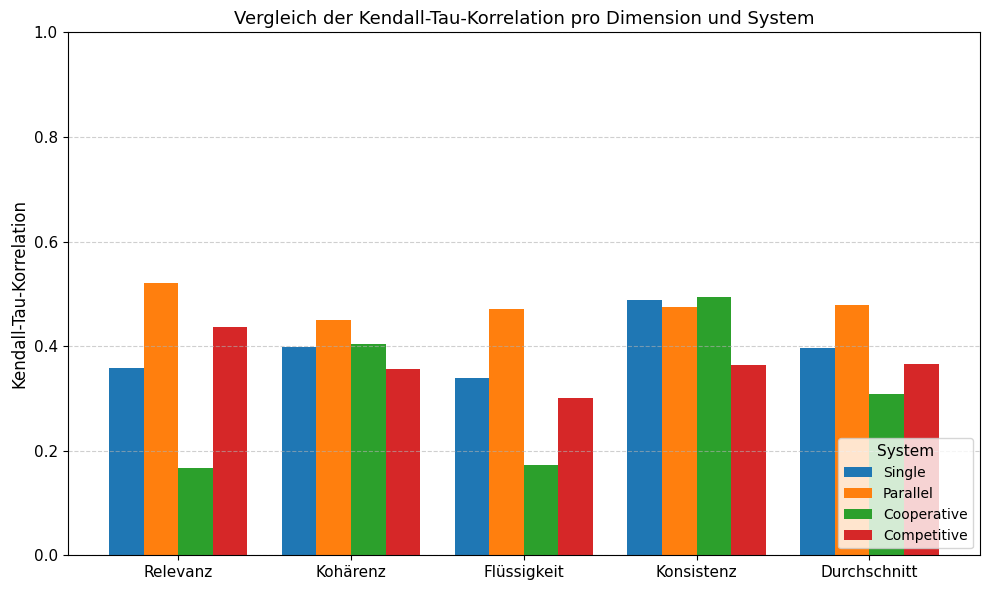

In [21]:
# Deutsche Beschriftungen
dimension_labels_de = ["Relevanz", "Kohärenz", "Flüssigkeit", "Konsistenz", "Durchschnitt"]
dimensions = ["relevance", "coherence", "fluency", "consistency", "average"]
systems = kendall_df["system"].tolist()

x = range(len(dimensions))
bar_width = 0.2
offsets = [-1.5, -0.5, 0.5, 1.5]

plt.figure(figsize=(10, 6))

# Verwende Standardfarben
for i, system in enumerate(systems):
    values = kendall_df.loc[kendall_df["system"] == system, dimensions].values.flatten()
    plt.bar(
        [pos + offsets[i] * bar_width for pos in x],
        values,
        width=bar_width,
        label=system
    )

# Achsen & Layout
plt.xticks(ticks=x, labels=dimension_labels_de, fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0.0, 1.0)  # Fixe Y-Achse für Kendall Tau
plt.ylabel("Kendall-Tau-Korrelation", fontsize=12)
plt.title("Vergleich der Kendall-Tau-Korrelation pro Dimension und System", fontsize=13)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="System", fontsize=10, title_fontsize=11, loc="lower right")
plt.tight_layout()

plt.show()


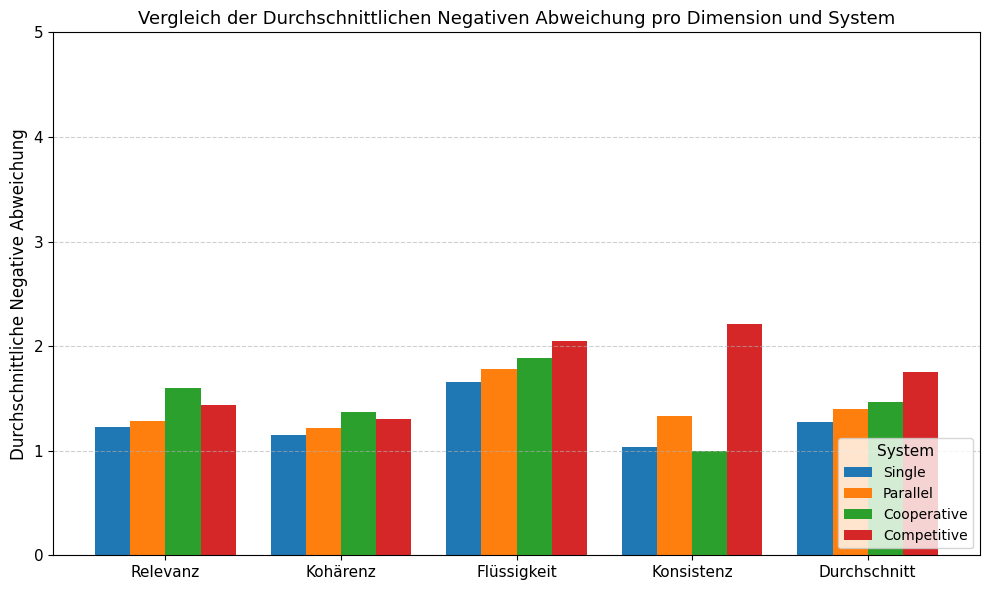

In [22]:
# Deutsche Beschriftungen für Achsen
dimension_labels_de = ["Relevanz", "Kohärenz", "Flüssigkeit", "Konsistenz", "Durchschnitt"]
dimensions = ["relevance", "coherence", "fluency", "consistency", "average"]
systems = deviation_df["system"].tolist()

# X-Positionen & Balkenbreite
x = range(len(dimensions))
bar_width = 0.2
offsets = [-1.5, -0.5, 0.5, 1.5]

# Neue Figure
plt.figure(figsize=(10, 6))

# Balken zeichnen
for i, system in enumerate(systems):
    values = deviation_df.loc[deviation_df["system"] == system, dimensions].values.flatten()
    plt.bar(
        [pos + offsets[i] * bar_width for pos in x],
        values,
        width=bar_width,
        label=system
    )

# Achsen & Layout
plt.xticks(ticks=x, labels=dimension_labels_de, fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0.0, 5.0)  # Fixe Y-Achse
plt.ylabel("Durchschnittliche Negative Abweichung", fontsize=12)
plt.title("Vergleich der Durchschnittlichen Negativen Abweichung pro Dimension und System", fontsize=13)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(title="System", fontsize=10, title_fontsize=11, loc="lower right")
plt.tight_layout()

plt.show()

